In [1]:
import pandas as pd
import numpy as np
import os
import gc
import datetime as dt
import warnings

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 20
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [12, 8]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 5))  
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.neural_network import MLPRegressor,MLPClassifier
from xgboost import XGBClassifier, XGBRegressor

from sklearn.linear_model import LassoCV,Lasso
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing

from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
#from alibi.explainers import ALE, plot_ale, AnchorTabular

import warnings 
warnings.filterwarnings('ignore')

#import alibi
import shap
#import eli5
#from h_stats import compute_h_all_pairs
from eli5.sklearn import PermutationImportance
from copy import deepcopy

from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from matplotlib import pyplot as plt

from h_stats import *



Using TensorFlow backend.


In [2]:
features = pd.read_csv('spx_cons_norm.csv')
features = features[['datadate','industry_id','forward_excess_ret','binary_class','multi_class','tic',
                     'abnormal_volume', 'MA3', 'MA6', 'MA12', 'EMA3', 'EMA6', 'EMA12',
                    'NI_growth', 'Size', 'PriceCap', 'ROE', 'ROA', 'ROI', 'NetPM',
                   'epspi12', 'earnings', 'earningsVol', 'Asset Turnover', 'PE', 'PB',
                   'PS', 'dividend_yield', 'ev_ebitda', 'NCFP']]
industry_dummy = pd.get_dummies(features['industry_id'])
features = pd.merge(features,industry_dummy,how='left',left_index=True,right_index=True)

features = features.dropna(subset=['forward_excess_ret','binary_class','multi_class'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)

cols = [col for col in features_after.columns if col not in ['datadate','industry_id','forward_excess_ret','binary_class','multi_class','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t


for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean
    
features_after['up_down'] = features_after['forward_excess_ret'].apply(lambda x: int(x>0))

In [3]:
linear = LinearRegression(fit_intercept=False)
DT = DecisionTreeRegressor(max_depth=10,random_state=0)
knn = KNeighborsRegressor(n_neighbors=50)
rf = RandomForestRegressor(max_depth=10)
ada = AdaBoostRegressor(random_state=0, n_estimators=100)
xg = XGBRegressor(max_depth=10)
gb = GradientBoostingRegressor(random_state=0, n_estimators=100)
mlp = MLPRegressor(solver='lbfgs', alpha=0.01,hidden_layer_sizes=(15,3), random_state=1)

In [26]:
class rolling_regression: 
    # df should be a cleaned dataframe with all factors and datadate
    # model is the regression model initialized(no warm start)
    # keyword can be forward_excess_ret, binary_class, multi_class and up_down
    def __init__(self,df,model,keyword='forward_excess_ret',frequency=12):
        self.df = df
        self.feature_names=['MA3','MA12','Size','ROI','PS','ev_ebitda','earningsVol','dividend_yield','epspi12']
        self.model = model
        self.keyword = keyword
        
        if type(self.model).__name__ == 'LinearRegression':
            self.shap_type = 'linear'
        elif type(self.model).__name__ == 'KNeighborsRegressor':
            self.shap_type = 'kernal'
        else:
            self.shap_type = 'tree'

        self.datelist = list(df['datadate'].drop_duplicates()) 
        self.selected_dates = []
        self.frequency = frequency

        self.trained_models = {}
        self.X_trains = {}
        self.y_trains = {}
        self.X_tests = {}
        self.y_tests = {}

        for m in range(max(6,self.frequency),len(self.datelist),self.frequency):
            date_range = self.datelist[max(0,m-12):m-1]
            train = df[df.datadate.isin(date_range)]
            X_train = train[self.feature_names]
            y_train = train[keyword]
            test = df[df.datadate == self.datelist[m]]
            X_test = test[self.feature_names]
            y_test = test[keyword]
            
            self.model.fit(X_train,y_train)
            
            self.trained_models[self.datelist[m]] = deepcopy(self.model)

            self.X_trains[self.datelist[m]] = X_train
            self.y_trains[self.datelist[m]] = y_train
            self.X_tests[self.datelist[m]] = X_test
            self.y_tests[self.datelist[m]] = y_test
            

            self.selected_dates.append(self.datelist[m])
    
    def feature_importance(self,selected_features=['MA3','MA12','Size','ROI','PS','ev_ebitda','earningsVol','dividend_yield','epspi12'],plot=False):
        print('###############################################################')
        print('Feature Importance')
        if plot:
            temp = pd.DataFrame()
            for m in self.selected_dates:
                feat_imp_df = eli5.explain_weights_df(self.trained_models[m], feature_names=self.feature_names)
                feat_imp_df['date'] = dt.datetime.strptime(str(m),'%Y%m%d')
                feat_imp_df.index = feat_imp_df.date
                
                temp = temp.append(feat_imp_df)
            temp = temp[temp['feature'].isin(selected_features)]
            temp.groupby('feature')['weight'].plot(legend=True)
            return(temp)
            
        else:
            print('###############################################################')
            for m in self.selected_dates:
                feat_imp_df = eli5.explain_weights_df(self.trained_models[m], feature_names=self.feature_names)   
                print('Date: ',m)
                print('--------------------------------------------')
                print(feat_imp_df)
                print('--------------------------------------------')
                
    def pdp_plots(self,selected_features=['MA3','MA12','Size','ROI','PS','ev_ebitda','earningsVol','dividend_yield','epspi12']):
        print('###############################################################')
        print('PDP plots')
        print('###############################################################')
        for m in self.selected_dates:
            features = list(range(len(selected_features)))
            
            plot_partial_dependence(self.trained_models[m], self.X_trains[m], features, feature_names=selected_features) 
            fig = plt.gcf()
            fig.set_size_inches(8,8) 
            
            title = 'Date: '+str(m)+' Partial Dependence Plots of '+str(type(self.model).__name__)
            fig.suptitle(title)
            fig.subplots_adjust(hspace=0.5)
            plt.show()
            
            print('--------------------------------------------')

        
    def h_stats_pairs(self,selected_features=['MA3','MA12','Size','ROI','PS','ev_ebitda','earningsVol','dividend_yield','epspi12']):
        print('###############################################################')
        print('h_stats_pairs')
        print('###############################################################')
        self.h_pairs = {}
        for m in self.selected_dates:
            print('Date: ',m)
            print('--------------------------------------------')
            temp = compute_h_all_pairs(self.trained_models[m],self.X_tests[m],self.feature_names,selected_features)
            temp = pd.DataFrame.from_dict(temp)
            temp.index=temp[0]
            print(temp[1])
            print('--------------------------------------------')
            self.h_pairs[m] = list(temp[0])
            
        
    
    def shap_interaction_plot(self, plot_features = ['MA3','MA12'], h_stats_based =False):
        print('SHAP dependence plot')
        print('###############################################################')
        if h_stats_based:
            for m in self.selected_dates: 
                if self.shap_type=='linear':
                    explainer = shap.LinearExplainer(self.trained_models[m],self.X_trains[m])
                elif self.shap_type == "kernal":
                    X_test_summary = shap.kmeans(self.X_tests[m], 10)
                    explainer = shap.KernelExplainer(self.trained_models.predict,X_test_summary)
                else:
                    explainer = shap.TreeExplainer(self.trained_models[m])
                
                shap_values = explainer.shap_values(self.X_tests[m])   
                shap_interaction = explainer.shap_interaction_values(self.X_tests[m])
                print('Date: ',m)
                print('--------------------------------------------')
                shap.dependence_plot(
                    (self.h_pairs[m][0][0], self.h_pairs[m][0][1]),
                    shap_interaction, self.X_tests[m],
                    display_features=self.X_tests[m]
                )
                print('--------------------------------------------')
        else:
            for m in self.selected_dates:
                if self.shap_type=='linear':
                    explainer = shap.LinearExplainer(self.trained_models[m],self.X_trains[m])
                elif self.shap_type == "kernal":
                    X_test_summary = shap.kmeans(self.X_tests[m], 10)
                    explainer = shap.KernelExplainer(self.trained_models.predict,X_test_summary)
                else:
                    explainer = shap.TreeExplainer(self.trained_models[m])

                shap_values = explainer.shap_values(self.X_tests[m])
                shap_interaction = explainer.shap_interaction_values(self.X_tests[m])
                
                
                print('Date: ',m)
                print('--------------------------------------------')
                shap.dependence_plot(
                    (plot_features[0], plot_features[1]),
                    shap_interaction, self.X_tests[m],
                    display_features=self.X_tests[m]
                )
                #shap.dependence_plot(plot_features[1], shap_values, self.X_tests[m], interaction_index=plot_features[0])
                
                
            print('###############################################################')
        
       

In [27]:
R = rolling_regression(features_after,rf,frequency=12)

###############################################################
PDP plots
###############################################################


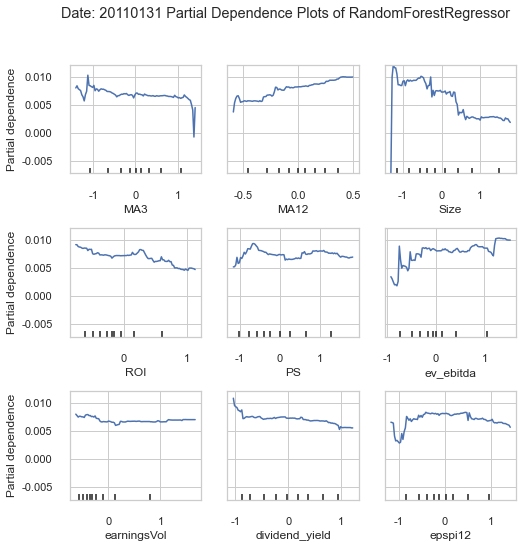

--------------------------------------------


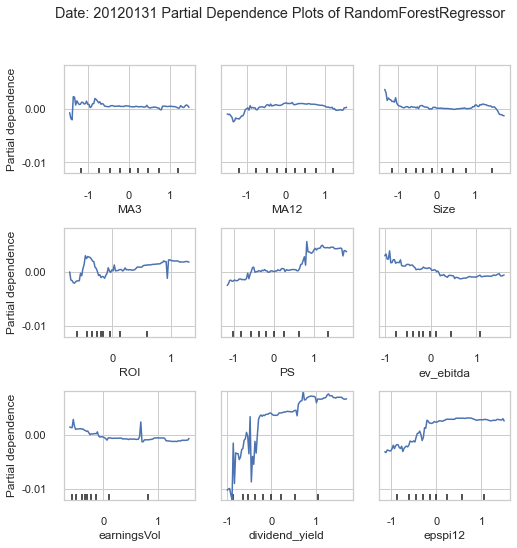

--------------------------------------------


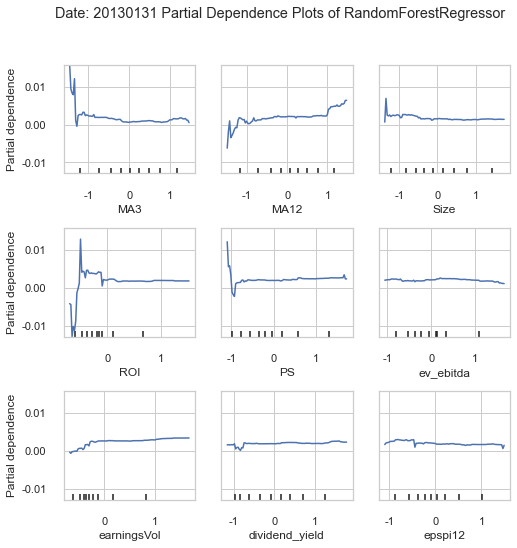

--------------------------------------------


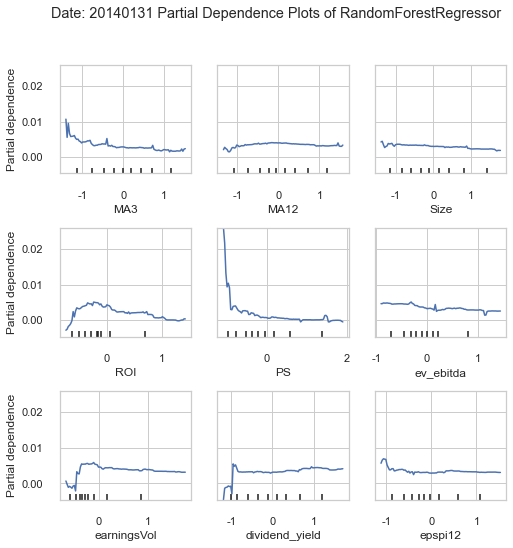

--------------------------------------------


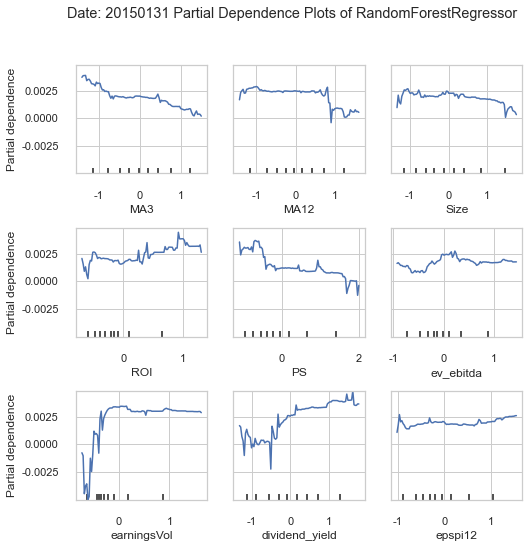

--------------------------------------------


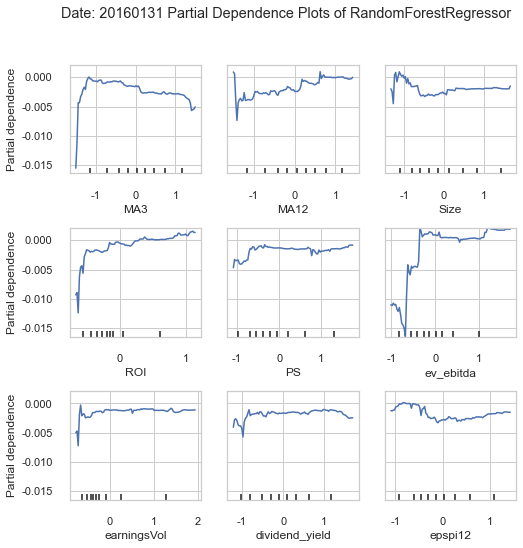

--------------------------------------------


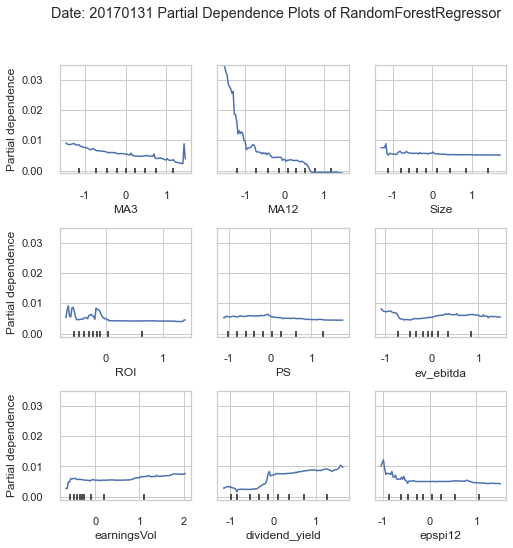

--------------------------------------------


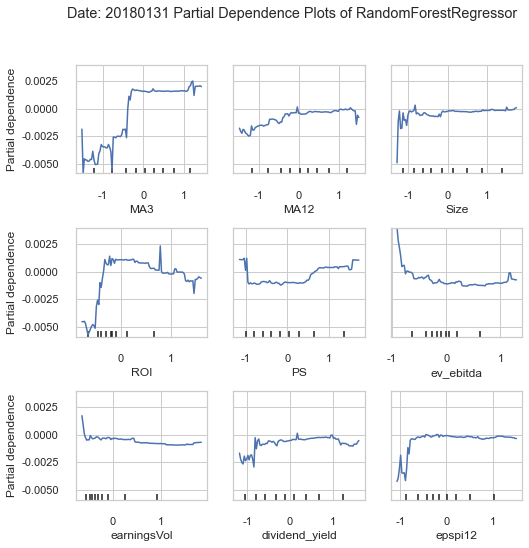

--------------------------------------------


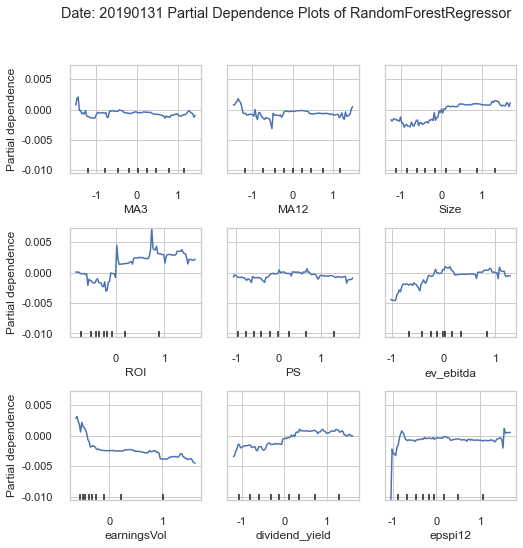

--------------------------------------------


In [39]:
R.pdp_plots()

In [28]:
R.h_stats_pairs()

###############################################################
h_stats_pairs
###############################################################
Date:  20110131
--------------------------------------------
0
(MA3, MA12)                      0.476865
(MA3, epspi12)                   0.346787
(Size, dividend_yield)           0.331361
(PS, dividend_yield)             0.329977
(MA12, ROI)                      0.320684
(dividend_yield, epspi12)        0.318328
(PS, epspi12)                    0.312215
(PS, earningsVol)                0.297170
(earningsVol, dividend_yield)    0.295236
(MA3, Size)                      0.292419
Name: 1, dtype: float64
--------------------------------------------
Date:  20120131
--------------------------------------------
0
(ROI, dividend_yield)            0.894463
(dividend_yield, epspi12)        0.732277
(MA3, Size)                      0.726507
(MA12, dividend_yield)           0.603023
(MA3, dividend_yield)            0.586781
(MA3, ROI)                       

SHAP dependence plot
###############################################################
Date:  20110131
--------------------------------------------


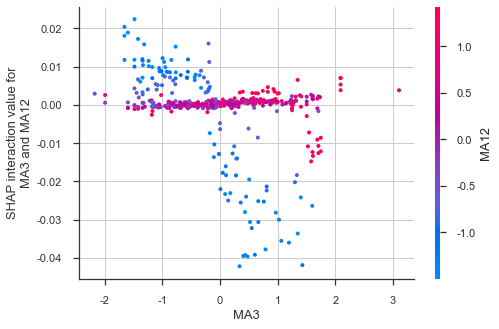

--------------------------------------------
Date:  20120131
--------------------------------------------


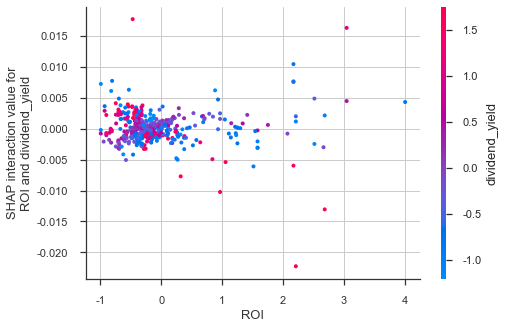

--------------------------------------------
Date:  20130131
--------------------------------------------


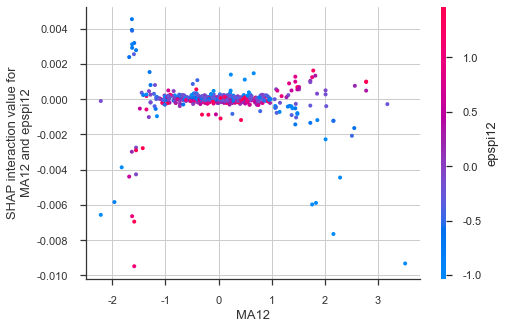

--------------------------------------------
Date:  20140131
--------------------------------------------


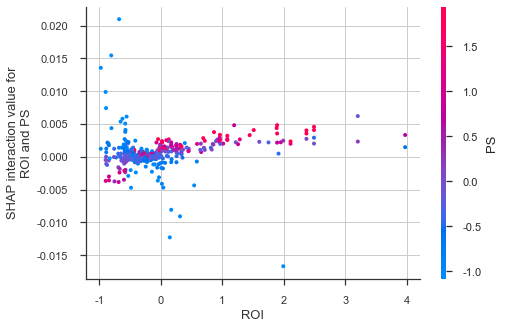

--------------------------------------------
Date:  20150131
--------------------------------------------


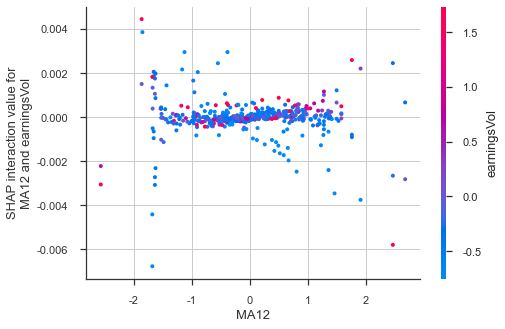

--------------------------------------------
Date:  20160131
--------------------------------------------


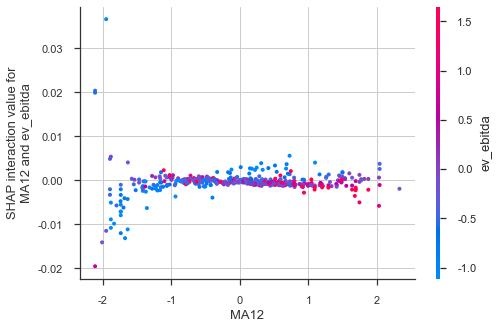

--------------------------------------------
Date:  20170131
--------------------------------------------


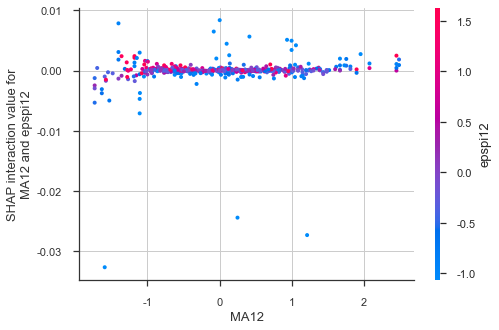

--------------------------------------------
Date:  20180131
--------------------------------------------


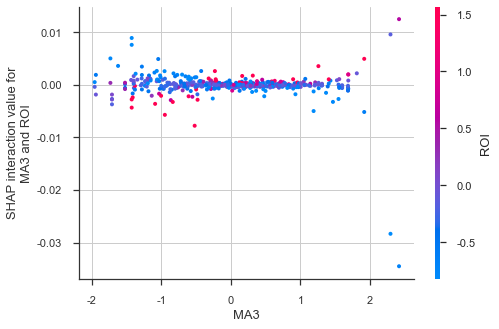

--------------------------------------------
Date:  20190131
--------------------------------------------


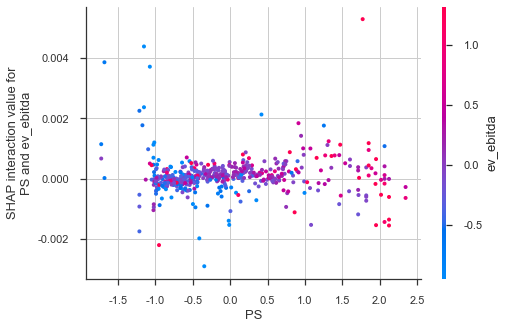

--------------------------------------------


In [29]:
R.shap_interaction_plot(h_stats_based=True)

In [5]:
from backtest import long_quantile,short_quantile,group_precision,backtest_rolling

In [11]:
feature_names = ['MA3','PS']
features_after['MA3_PS'] = features_after.apply(temp,axis=1)

Linear:


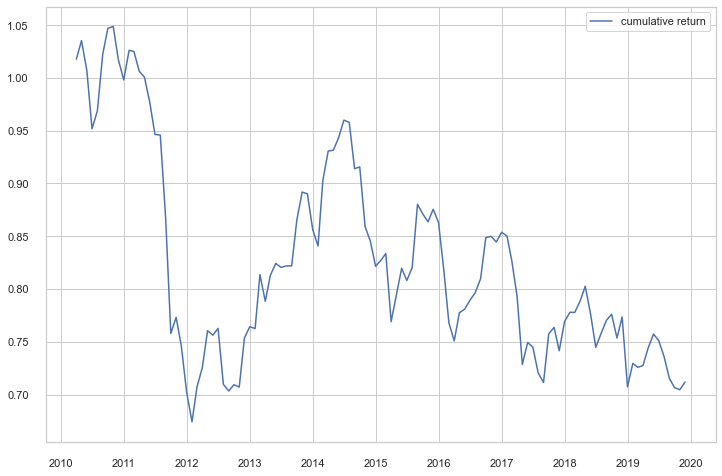

Annual_ret: -0.029551087841537017 

Sharpe Ratio: -0.29431818423882367 

Max_drawdown: 0.2978371731291948


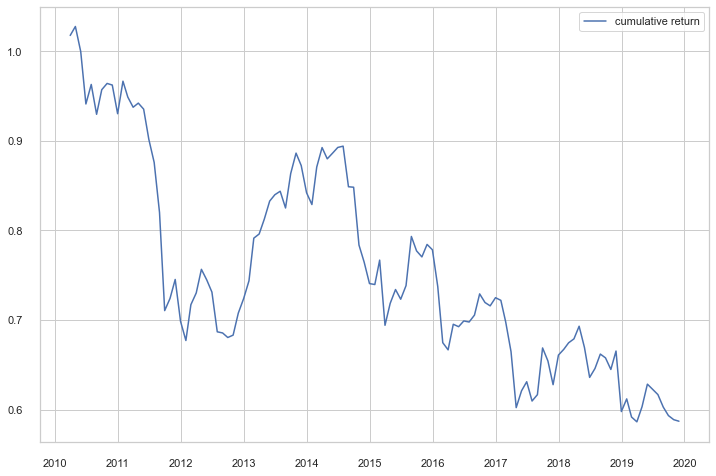

Annual_ret: -0.04236201314133769 

Sharpe Ratio: -0.4392375376581084 

Max_drawdown: 0.242776643283659


In [12]:
print('Linear:')
model = LinearRegression(fit_intercept=False) 
p_linear = backtest_rolling(features_after,model,keyword='forward_excess_ret',feature_names=feature_names)

model = LinearRegression(fit_intercept=False) 
p_linear = backtest_rolling(features_after,model,keyword='forward_excess_ret',feature_names=feature_names+['MA3_PS'])

## Regression - MA3

In [202]:
R.X_tests[20110131]

,MA3,MA12,Size,ROI,PS,ev_ebitda,earningsVol,dividend_yield,epspi12
5824,-0.382145,0.321685,-1.081307,0.410075,0.745308,0.138137,-0.168197,0.753739,-0.035212
5825,-1.657909,-1.640195,1.617948,-0.469536,-0.144065,-0.473362,-0.034280,2.084097,-0.076724
5826,-0.280555,-0.830215,-0.688030,-0.666152,-1.110549,0.029426,1.115576,-0.579352,-0.565239
5827,0.153572,0.019802,-0.204875,-0.423301,-1.095387,0.088773,-0.277072,-0.500613,0.470572
5828,-0.813520,-0.774173,0.775212,-0.413848,0.376970,-0.504486,-0.297433,0.769012,0.965146
...,...,...,...,...,...,...,...,...,...
6304,-1.485105,-0.601374,-0.519449,-0.024459,1.571761,-0.200074,-0.249596,-0.392061,-0.169560
6305,-0.188665,0.591752,-0.186809,3.266114,2.061036,1.727118,-0.778258,-0.341974,-0.091129
6306,-0.105247,-0.727993,-1.114396,-0.354366,-0.309028,-0.363721,-0.410458,-0.583739,-1.248038
6307,2.091413,1.730628,-0.326332,2.251951,-1.155981,-0.065971,0.738947,2.069538,-0.764889


In [232]:
np.append(np.nan,temp,axis=0).shape

ValueError: zero-dimensional arrays cannot be concatenated

In [230]:
temp.shape

(485, 9)